In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [49]:
import numpy as np
import h5py
from abc import ABC, abstractmethod
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set()

In [200]:
class DiscriminativeModel(ABC):
    @abstractmethod
    def fit(self, X, y, sample_weight=None, **kwargs):
        pass
    
    @abstractmethod
    def predict(self, X):
        pass
    
    @abstractmethod
    def predict_proba(X):
        pass

    def init_params(self, **kwargs):
        pass
    
class IterativeEnrich(DiscriminativeModel):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None, sample_weight=None, tol=1e-3, fit_kw=None, predict_kw=None, max_iter=1000):
        if y is None:
            # assign labels to random values
            y = np.random.randint(2, size=X.shape[0], dtype=np.int32)
        else:
            y = y.flatten().astype(np.int32)
        if fit_kw is None:
            fit_kw = {}
        if predict_kw is None:
            predict_kw = {}
        y_prev = y
        i_iter = 0
        while i_iter < max_iter:
            self.estimator.fit(X, y_prev, **fit_kw)
            y_probas = self.estimator.predict_proba(X, **predict_kw)
            y_labels = (y_probas[:, 1] >= 0.5).astype(np.int32)
            error_rate = np.mean(~np.equal(y_labels, y_prev))
            i_iter += 1
            if error_rate < tol:
                break
            y_prev = y_labels
            #print('iter = {}, error rate = {}'.format(i_iter, error_rate))
        print('optimized in {} iterations'.format(i_iter))
    
    def predict(self, X):
        return self.estimator.predict(X)
    
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)
    
    def init_params(self, **kwargs):
        self.estimator.init_params(**kwargs)

In [177]:
def make_normal_uniform(n_samples, n_features=2, positive_ratio=0.5):
    n_positives = round(n_samples*positive_ratio)
    n_negatives = n_samples - n_positives
    X = np.empty((n_samples, n_features))
    X[:n_positives] = np.random.normal(size=(n_positives, n_features))
    X[n_positives:] = np.random.uniform(-8, 8, size=(n_negatives, n_features))
    y = np.zeros(n_samples, dtype=np.int32)
    y[:n_positives] = 1
    indices = np.random.permutation(n_samples)
    X = X[indices]
    y = y[indices]
    return X, y

Accuracy of LogisticRegression: 0.558
Accuracy of RandomForestClassifier: 0.521


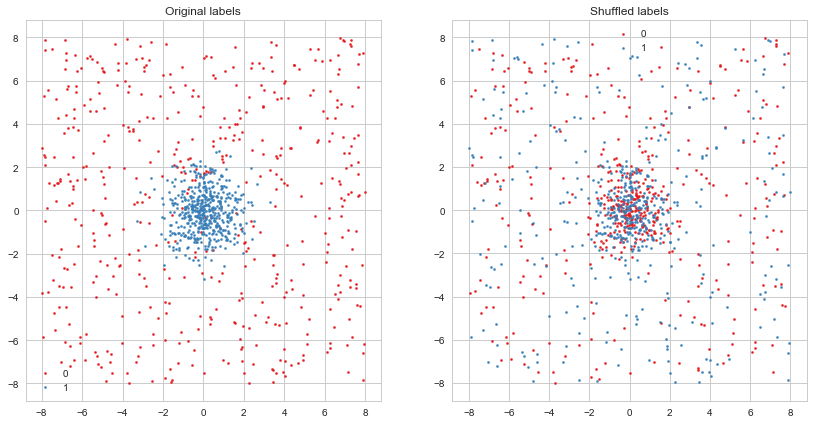

In [185]:
#X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
#                           n_classes=2, n_clusters_per_class=1)
X, y = make_normal_uniform(n_samples=1000)
# permutate y
y_shuffled = y.copy()
np.random.shuffle(y_shuffled)

for estimator_class in (LogisticRegression, RandomForestClassifier):
    estimator = estimator_class()
    estimator.fit(X, y_shuffled)
    accuracy = estimator.score(X, y)
    print('Accuracy of {}: {}'.format(estimator_class.__name__, accuracy))

sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
for i in range(2):
    for label in (0, 1):
        if i == 0:
            mask = (y == label)
        elif i == 1:
            mask = (y_shuffled == label)
        axes[i].scatter(X[mask, 0], X[mask, 1], c=cm.Set1(label), s=5, cmap=cm.Set1, label=label)
    axes[i].legend()
axes[0].set_title('Original labels')
axes[1].set_title('Shuffled labels')
pass

optimized in 3 iterations
Accuracy of IterativeEnrich: 0.628


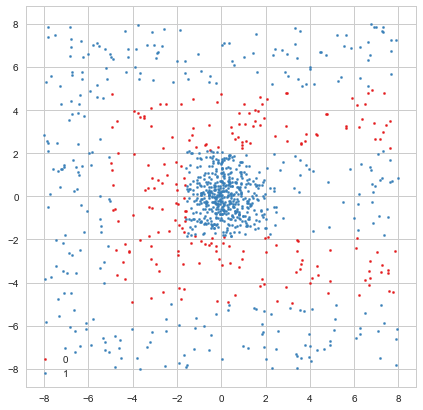

In [223]:
#enrich = IterativeEnrich(LogisticRegression())
enrich = IterativeEnrich(RandomForestClassifier(n_estimators=10, max_depth=4))
# sample more negative samples
X_neg = np.random.uniform(-5, 5, size=X.shape)
X_aug = np.concatenate([X_neg, X], axis=0)
y_aug = np.concatenate([np.zeros(X.shape[0], dtype=np.int32),
                        np.ones(X.shape[0], dtype=np.int32)])
#enrich.fit(X, y_shuffled, max_iter=10)
enrich.fit(X_aug, y_aug, max_iter=100)
y_pred = enrich.predict(X)
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(7, 7))
for label in (0, 1):
    mask = (y_pred == label)
    ax.scatter(X[mask, 0], X[mask, 1], c=cm.Set1(label), s=5, cmap=cm.Set1, label=label)
ax.legend()
print('Accuracy of IterativeEnrich: {}'.format(accuracy_score(y, y_pred)))
pass

In [230]:
(np.ones(10) == 1) & (np.ones(10) == 0)

array([False, False, False, False, False, False, False, False, False,
       False])